# <font color='#A52A2A'>Enhancing ZOS API using PyZOS library</font>

In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
from IPython.display import display, Image, YouTubeVideo
import matplotlib.pyplot as plt

# Imports for using ZOS API in Python directly with pywin32
# (not required if using PyZOS)
from win32com.client.gencache import EnsureDispatch, EnsureModule
from win32com.client import CastTo, constants

# Import for using ZOS API in Python using PyZOS
import pyzos.zos as zos

## <font color='#008000'>Reference</font>

We will use the following two Zemax knowledgebase articles as base material for this discussion. Especially, the code from the first article is used to compare and illustrate the enhanced features of PyZOS library.


1. "[How to build and optimize a singlet using ZOS-API with Python](http://www.zemax.com/support/resource-center/knowledgebase/how-to-build-and-optimize-a-singlet-using-zos-api)," Zemax KB, 12/16/2015, Thomas Aumeyr. 

2. "[Interfacing to OpticStudio from Mathematica](http://www.zemax.com/support/resource-center/knowledgebase/interfacing-to-opticstudio-from-mathematica)," Zemax KB, 05/03/2015, David.

In [2]:
# Set this variable to True or False to use ZOS API with  
# the PyZOS library or without it respectively.
USE_PYZOS = True

## <font color='#008000'>Enhancements</font>

### <font color='#005078'>1. Visible UI for the headless standalone ZOS-API COM application</font>

The PyZOS library provides two functions `zPushLens()` and `zGetRefresh()` whose function is to copy the lens from the headless ZOS COM server to the running UI and from the running UI to the headless ZOS COM server respectively. 

However, in order to use these features the `OpticalSystem` has to be instantiated with the parameter `sync_ui` set to `True` (see the screen-shot video).



(If you cannot see the video in the frame below, or if the resolution is not good enough within this notebook, here is a direct link to the Youtube video: https://www.youtube.com/watch?v=ot5CrjMXc_w&feature=youtu.be)

In [3]:
# a screenshot video of the feature:
display(YouTubeVideo("ot5CrjMXc_w?t", width=900, height=600))

### <font color='#005078'>2. Initialization of ZOS API Interface and instantiation of an Optical System</font>

The first enhancement is the complete elimination of boiler-plate code to get create and initialize an optical system object and get started. We just need to create an instance of a PyZOS `OpticalSystem` to get started. The optical system can be either a sequential or a non-sequential system. 

In [4]:
if USE_PYZOS:
    osys = zos.OpticalSystem()     # Directly get the Primary Optical system
else:
    # using ZOS API directly with pywin32
    EnsureModule('ZOSAPI_Interfaces', 0, 1, 0)
    connect = EnsureDispatch('ZOSAPI.ZOSAPI_Connection')
    app = connect.CreateNewApplication() # The Application
    osys = app.PrimarySystem             # Optical system (primary)
    
# common 
osys.New(False)

It may seem that if we are using PyZOS, then the application is not available. In fact, it is available through a property of the PyZOS `OpticalSystem` object:

In [5]:
if USE_PYZOS:
    print(osys.pTheApplication)

### <font color='#005078'>3.  Introspection of properties of ZOS objects on <kbd>Tab</kbd> press</font>

Because of the way property attributes are mapped by the PyWin32 library, the properties are not introspectable (visible) on <kbd>Tab</kbd> press in smart editors such as IPython. Only the methods are shown upon pressing the <kbd>Tab</kbd> button (see figure below). Note that although the properties are not "visible" they are still accessible. 

PyZOS enhances the user experience by showing both the method and the properties of the ZOS object (by creating a wrapped object and delegating the attribute access to the underlying ZOS API COM objects). In addition, the properties are easily identified by the prefix <font color='magenta'><b>p</b></font> in front of the property attribute names.

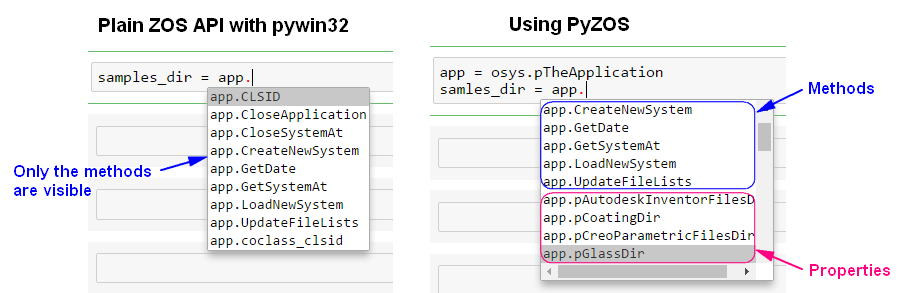

In [6]:
Image('./images/00_01_property_attribute.png')

In [7]:
if USE_PYZOS:
    sdir = osys.pTheApplication.pSamplesDir
else:
    sdir = osys.TheApplication.SamplesDir

### <font color='#005078'>4. Ability to override methods of ZOS objects</font>

There are some reasons why we may want to override some of the methods provided by ZOS. As an example, consider the `SaveAs` method of `OpticalSystem` that accepts a `filename`. If the `filename` is invalid the `SaveAs` method doesn't raise any exception/error, instead the lens data is saved to the default file "Lens.zmx".

This function in PyZOS has been overridden to raise an exception if the directory path is not valid, as shown below:

In [8]:
file_out = os.path.join(sdir, 'invalid_directory', 
                       'Single Lens Example wizard+EFFL.zmx')
try:
    osys.SaveAs(file_out)
except Exception as err:
    print(repr(err))

ValueError('C:\\Users\\Indranil\\Documents\\ZEMAX\\SAMPLES\\invalid_directory is not valid.',)


In [9]:
file_out = os.path.join(sdir, 'Sequential', 'Objectives', 
                       'Single Lens Example wizard+EFFL.zmx')
osys.SaveAs(file_out)

In [10]:
# Aperture
if USE_PYZOS:
    sdata = osys.pSystemData
    sdata.pAperture.pApertureValue = 40
else:
    sdata = osys.SystemData 
    sdata.Aperture.ApertureValue = 40

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module isdaperturedata_methods found
  exec(module_import_str, globals(), cdict)


NOTE: Don't be alarmed by the ominous looking warning message above (if USE_PYZOS is `True`). It just indicates that the particular ZOS API COM object has been wrapped but PyZOS didn't find any custom method to add to the wrapped class. Currently, the warnings are turned on to identify and help development of the PyZOS library. The warnings can be easily turned off. 

In [11]:
# Set Field data
if USE_PYZOS:
    field = sdata.pFields.AddField(0, 5.0, 1.0)
    print('Number of fields =', sdata.pFields.pNumberOfFields)
else:
    field = sdata.Fields.AddField(0, 5.0, 1.0)
    print('Number of fields =', sdata.Fields.NumberOfFields)

Number of fields = 2


C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module ifield_methods found
  exec(module_import_str, globals(), cdict)


### <font color='#005078'>5. <kbd>Tab</kbd> completion and introspection of API constants</font>

The ZOS API provides a large set of enumerations that are accessible as constants through the `constants` object of PyWin32. However, they are not introspectable using the <kbd>Tab</kbd> key. PyZOS automatically retrieves the constants and makes them introspectable as shown below: 

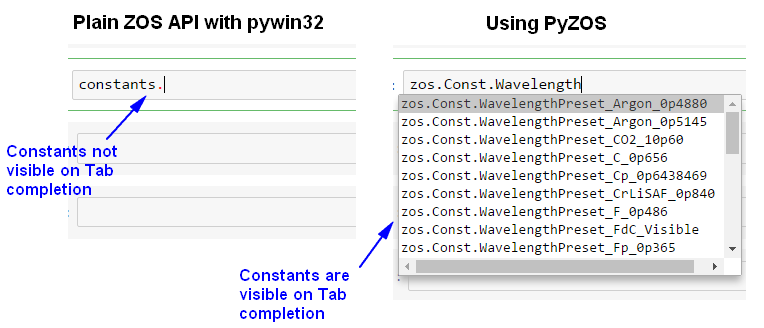

In [12]:
Image('./images/00_02_constants.png')

In [13]:
# Setting wavelength using wavelength preset
if USE_PYZOS:
    sdata.pWavelengths.SelectWavelengthPreset(zos.Const.WavelengthPreset_d_0p587);
else:
    sdata.Wavelengths.SelectWavelengthPreset(constants.WavelengthPreset_d_0p587);

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module iwavelengths_methods found
  exec(module_import_str, globals(), cdict)


### <font color='#005078'>6. Ability to add custom methods and properties to any ZOS API object</font>

PyZOS allows us to easily extend the functionality of any ZOS API object by adding custom *methods* and *properties*, supporting the idea of developing a useful library over time. In the following block of codes we have added custom methods `zInsertNewSurfaceAt()` and `zSetSurfaceData()` to the `OpticalSystem` ojbect. 

(Please note there is <u>no</u> implication that one cannot build a common set of *functions* without using PyZOS. Here, we only show that PyZOS allows us to add *methods* to the ZOS objects. How to add new *methods* PyZOS objects will be explained later.) 

In [14]:
# Set Lens data Editor
if USE_PYZOS:
    osys.zInsertNewSurfaceAt(1)
    osys.zInsertNewSurfaceAt(1)
    osys.zSetSurfaceData(1, thick=10, material='N-BK7', comment='front of lens')
    osys.zSetSurfaceData(2, thick=50, comment='rear of lens')
    osys.zSetSurfaceData(3, thick=350, comment='Stop is free to move')
else:
    lde = osys.LDE
    lde.InsertNewSurfaceAt(1)
    lde.InsertNewSurfaceAt(1)
    surf1 = lde.GetSurfaceAt(1)
    surf2 = lde.GetSurfaceAt(2)
    surf3 = lde.GetSurfaceAt(3)
    surf1.Thickness = 10.0
    surf1.Comment = 'front of lens'
    surf1.Material = 'N-BK7'
    surf2.Thickness = 50.0
    surf2.Comment = 'rear of lens'
    surf3.Thickness = 350.0
    surf3.Comment = 'Stop is free to move'

The custom functions are introspectable, and they are identified by the prefix <font color='magenta'><b>z</b></font> to their names as shown in the following figure.

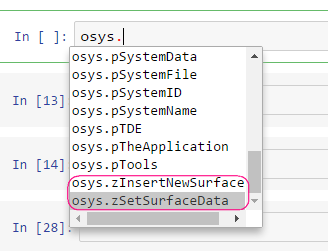

In [15]:
Image('./images/00_03_extendiblity_custom_functions.png')

In [16]:
# Setting solves - Make thickness and radii variable
# nothing to demonstrate in particular in this block of code

if USE_PYZOS:
    osys.pLDE.GetSurfaceAt(1).pRadiusCell.MakeSolveVariable()
    osys.pLDE.GetSurfaceAt(1).pThicknessCell.MakeSolveVariable()
    osys.pLDE.GetSurfaceAt(2).pRadiusCell.MakeSolveVariable()
    osys.pLDE.GetSurfaceAt(2).pThicknessCell.MakeSolveVariable()
    osys.pLDE.GetSurfaceAt(3).pThicknessCell.MakeSolveVariable()
else:
    surf1.RadiusCell.MakeSolveVariable()
    surf1.ThicknessCell.MakeSolveVariable()
    surf2.RadiusCell.MakeSolveVariable()
    surf2.ThicknessCell.MakeSolveVariable()
    surf3.ThicknessCell.MakeSolveVariable()

In [17]:
# Setting up the default merit function 
# this code block again shows that we can create add custom methods 
# based on our requirements
if USE_PYZOS:
    osys.zSetDefaultMeritFunctionSEQ(ofType=0, ofData=1, ofRef=0, rings=2, arms=0, grid=0, 
                                     useGlass=True, glassMin=3, glassMax=15, glassEdge=3, 
                                     useAir=True, airMin=0.5, airMax=1000, airEdge=0.5)
else:
    mfe = osys.MFE
    wizard = mfe.SEQOptimizationWizard
    wizard.Type = 0          # RMS
    wizard.Data = 1          # Spot Radius
    wizard.Reference = 0     # Centroid
    wizard.Ring = 2          # 3 Rings
    wizard.Arm = 0           # 6 Arms
    wizard.IsGlassUsed = True
    wizard.GlassMin = 3
    wizard.GlassMax = 15
    wizard.GlassEdge = 3
    wizard.IsAirUsed = True
    wizard.AirMin = 0.5
    wizard.AirMax = 1000
    wizard.AirEdge = 0.5
    wizard.IsAssumeAxialSymmetryUsed = True
    wizard.CommonSettings.OK()

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module iseqoptimizationwizard_methods found
  exec(module_import_str, globals(), cdict)


Here we can demonstrate another strong reason why we may require to add methods to ZOS objects when using the ZOS API with `pywin32` library. The problem is illustrated in the figure below. According to the ZOS API manual, the MFE object (`IMeritFunctionEditor`) should have the methods `AddRow()`, `DeleteAllRows()`, `DeleteRowAt()`, `DeleteRowsAt()`, `InsertRowAt()` and `GetRowAt()` that it inherits from `IEditor` object. However, due to the way `pywin32` handles inheritence, these methods (defined in the base class) are apparently not available to the derived class object [[1](#Reference)]. 

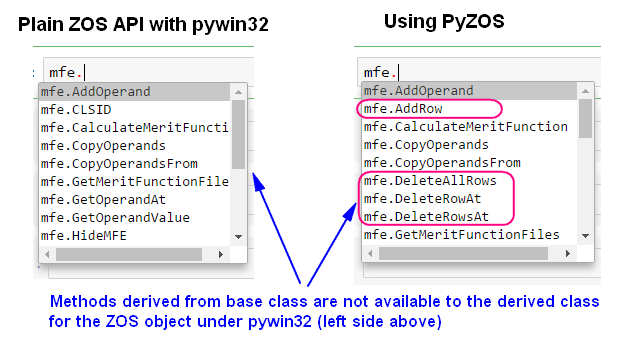

In [18]:
Image('./images/00_04_extendiblity_required_methods.png')

In order to solve the above problem in PyZOS, currently we "add" these methods to the derived (and wrapped) objects and delegate the calls to the base class. (Probably there is a more intelligent method of solving this ... which will not require so much code re-writing!) 

### <font color='#005078'>7. Wrap objects that are not yet wrapped in PyZOS</font>

Currently, the wrapping of ZOS objects are not automatic. Therefore, all ZOS objects have not been wrapped. The PyZOS library exposes the function that is used internally to wrap ZOS object -- `wrapped_zos_object()`. This functions returns a wrapped PyZOS object (created dynamically) with the methods and properties of the underlying ZOS object exposed for introspection. 

In [19]:
# Add operand
if USE_PYZOS:
    mfe = osys.pMFE
    operand1 = mfe.InsertNewOperandAt(1)
    print('Attributes of operands1 before wrapping:')
    print([each for each in dir(operand1) if not each.startswith('_')])
    operand1 = zos.wrapped_zos_object(operand1)
    print('\nAttributes of operands1 after wrapping:')
    print([each for each in dir(operand1) if not each.startswith('_')])
    operand1.ChangeType(zos.Const.MeritOperandType_EFFL)
    operand1.pTarget = 400.0
    operand1.pWeight = 1.0
else:
    operand1 = mfe.InsertNewOperandAt(1)
    operand1.ChangeType(constants.MeritOperandType_EFFL)
    operand1.Target = 400.0
    operand1.Weight = 1.0

Attributes of operands1 before wrapping:
['AvailableOperandTypes', 'CLSID', 'ChangeType', 'GetOperandCell', 'coclass_clsid']

Attributes of operands1 after wrapping:
['AvailableOperandTypes', 'ChangeType', 'GetOperandCell', 'pContribution', 'pContributionCell', 'pIsActive', 'pOperandNumber', 'pRowColor', 'pTarget', 'pTargetCell', 'pType', 'pTypeName', 'pValue', 'pValueCell', 'pWeight', 'pWeightCell']


C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module imferow_methods found
  exec(module_import_str, globals(), cdict)


In [20]:
# Local optimization
if USE_PYZOS:
    local_opt = osys.pTools.OpenLocalOptimization()
    local_opt.pAlgorithm = zos.Const.OptimizationAlgorithm_DampedLeastSquares
    local_opt.pCycles = zos.Const.OptimizationCycles_Automatic
    local_opt.pNumberOfCores = 8
    local_opt.RunAndWaitForCompletion()
    local_opt.Close()
else:
    local_opt = osys.Tools.OpenLocalOptimization()
    local_opt.Algorithm = constants.OptimizationAlgorithm_DampedLeastSquares
    local_opt.Cycles = constants.OptimizationCycles_Automatic
    local_opt.NumberOfCores = 8
    base_tool = CastTo(local_opt, 'ISystemTool')
    base_tool.RunAndWaitForCompletion()
    base_tool.Close()

In [21]:
# save the latest changes to the file
osys.Save()

## <font color='#008000'>Create a second optical system to load a standard lens for FFT MTF analysis</font>

In [22]:
%matplotlib inline

In [23]:
osys2 = zos.OpticalSystem()

In [24]:
# load a lens into the Optical System
lens = 'Cooke 40 degree field.zmx'
zfile = os.path.join(sdir, 'Sequential', 'Objectives', lens)
osys2.LoadFile(zfile, False)

True

In [25]:
osys2.pSystemName

u'A SIMPLE COOKE TRIPLET.'

In [26]:
# check the aperture
osys2.pSystemData.pAperture.pApertureValue

10.0

In [27]:
# a more detailed information about the pupil 
osys2.pLDE.GetPupil()

pupil_data(ZemaxApertureType=0, ApertureValue=10.0, entrancePupilDiameter=10.0, entrancePupilPosition=11.512157051593944, exitPupilDiameter=10.233727882412548, exitPupilPosition=-50.96133885157397, ApodizationType=0, ApodizationFactor=0.0)

In [28]:
# Thickness of a surface    
surf6 = osys2.pLDE.GetSurfaceAt(6)
surf6.pThickness

42.2077801

In [29]:
# Thickness of surface through custom added method 
osys2.zGetSurfaceData(6).thick

42.2077801

In [30]:
# Open Analysis windows in the system currently
num_analyses = osys2.pAnalyses.pNumberOfAnalyses
for i in range(num_analyses):
    print(osys2.pAnalyses.Get_AnalysisAtIndex(i+1).pGetAnalysisName)

Draw2D
RayFan
StandardSpot


In [31]:
#mtf analysis
fftMtf = osys2.pAnalyses.New_FftMtf() # open a new FFT MTF window
fftMtf

In [32]:
fftMtf_settings = fftMtf.GetSettings()
fftMtf_settings

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module ias_fftmtf_methods found
  exec(module_import_str, globals(), cdict)


In [33]:
# Set the maximum frequency to 160 lp/mm
fftMtf_settings.pMaximumFrequency = 160.0

In [34]:
# run the analysis
fftMtf.ApplyAndWaitForCompletion()

In [35]:
# results
fftMtf_results = fftMtf.GetResults() # returns an <pyzos.zosutils.IAR_ object

In [36]:
# info about the result data
print('Number of data grids:', fftMtf_results.pNumberOfDataGrids)
print('Number of data series:', fftMtf_results.pNumberOfDataSeries)

Number of data grids: 0
Number of data series: 4


In [37]:
ds = zos.wrapped_zos_object(fftMtf_results.GetDataSeries(1))

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module iar_dataseries_methods found
  exec(module_import_str, globals(), cdict)


In [38]:
ds.pDescription

u'Field: 0.00 (deg)'

In [39]:
ds.pNumSeries

2

In [40]:
ds.pSeriesLabels

(u'Tangential', u'Sagittal')

Since these objects has not been wrapped (at the time of this writing), we will wrap them first

In [41]:
dsXdata = zos.wrapped_zos_object(ds.pXData)
dsYdata = zos.wrapped_zos_object(ds.pYData)

C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module ivectordata_methods found
  exec(module_import_str, globals(), cdict)
C:\PROGRAMSANDEXPERIMENTS\PYTHON\OPTICS\PyZOS\pyzos\zosutils.py:140: UserWarning: No module imatrixdata_methods found
  exec(module_import_str, globals(), cdict)


In [42]:
freq = np.array(dsXdata.pData)
mtf = np.array(dsYdata.pData) # shape = (len(freq) , ds.pNumSeries) 

In [43]:
# build a function to plot the FFTMTF 
def plot_FftMtf(optical_system, max_freq=160.0):
    fftMtf = optical_system.pAnalyses.New_FftMtf()
    fftMtf.GetSettings().pMaximumFrequency = max_freq
    fftMtf.ApplyAndWaitForCompletion()
    fftMtf_results = fftMtf.GetResults()

    fig, ax = plt.subplots(1,1, figsize=(8,6))
    num_dataseries = fftMtf_results.pNumberOfDataSeries
    col = ['#0080FF', '#F52080', '#00CC60', '#B96F20', '#1f77b4', 
           '#ff7f0e', '#2ca02c', '#8c564b', '#00BFFF', '#FF8073'] 

    for i in range(num_dataseries):
        ds = zos.wrapped_zos_object(fftMtf_results.GetDataSeries(i))
        dsXdata = zos.wrapped_zos_object(ds.pXData)
        dsYdata = zos.wrapped_zos_object(ds.pYData)
        freq = np.array(dsXdata.pData)
        mtf = np.array(dsYdata.pData) # shape = (len(freq) , ds.pNumSeries) 
        ax.plot(freq[::5], mtf[::5, 0], color=col[i], lw=1.5, label=ds.pDescription) # tangential
        ax.plot(freq[::5], mtf[::5, 1], '--', color=col[i], lw=2) # sagittal
        ax.set_xlabel('Spatial Frequency (lp/mm)')
        ax.set_ylabel('FFT MTF')
        ax.legend()
    plt.text(0.85, -0.1,u'\u2014 {}'.format(ds.pSeriesLabels[0]), transform=ax.transAxes)
    plt.text(0.85, -0.15,'-- {}'.format(ds.pSeriesLabels[1]), transform=ax.transAxes)
    plt.grid()
    plt.show()

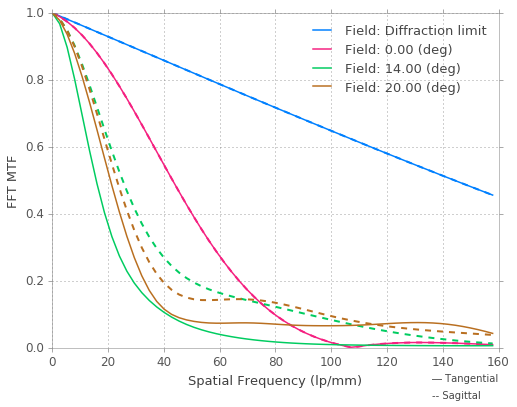

In [44]:
# FFT MTF of Optical System 2
plot_FftMtf(osys2)

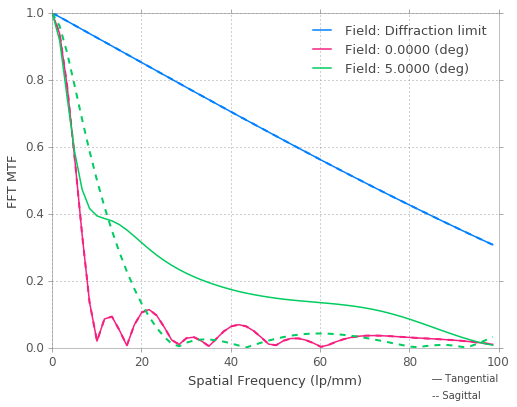

In [45]:
# FFT MTF of Optical System 1
plot_FftMtf(osys, 100)

In [46]:
# Close the application
if USE_PYZOS:
    app = osys.pTheApplication
app.CloseApplication()
del app